# Projet Machine Learning

Antonin Arsac \
Mathilde Perez

les previsions du premier reseau de neurones sont égales à 0.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 

from sklearn.metrics import roc_curve,auc

### Chargements de dataframe

In [2]:
df_cardio1=pd.read_csv("./data/annotations/cardiologist1.csv")
df_cardio2=pd.read_csv("./data/annotations/cardiologist2.csv")
df_cardior=pd.read_csv("./data/annotations/cardiology_residents.csv")
df_dnn=pd.read_csv("./data/annotations/dnn.csv")
df_emergency=pd.read_csv("./data/annotations/emergency_residents.csv")
df_gold_s=pd.read_csv("./data/annotations/gold_standard.csv")
df_students=pd.read_csv("./data/annotations/medical_students.csv")
df_attributes=pd.read_csv("./data/attributes.csv")

In [96]:
del df_dnn['Unnamed: 0']

### Predictions

In [97]:
import argparse
#warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from datasets import ECGSequence


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
    parser.add_argument('path_to_hdf5', type=str,
                        help='path to hdf5 file containing tracings')
    parser.add_argument('path_to_model',  # or model_date_order.hdf5
                        help='file containing training model.')
    parser.add_argument('--dataset_name', type=str, default='tracings',
                        help='name of the hdf5 dataset containing tracings')
    parser.add_argument('--output_file', default="./dnn_output.npy",  # or predictions_date_order.csv
                        help='output csv file.')
    parser.add_argument('-bs', type=int, default=32,
                        help='Batch size.')

    args, unk = parser.parse_known_args(["./data/ecg_tracings.hdf5","./model/model.hdf5"])
    if unk:
        warnings.warn("Unknown arguments:" + str(unk) + ".")

    # Import data
    seq = ECGSequence(args.path_to_hdf5, args.dataset_name, batch_size=args.bs)
    # Import model
    model = load_model(args.path_to_model, compile=False)
    model.compile(loss='binary_crossentropy', optimizer=Adam())
    y_score = model.predict(seq,  verbose=1)

    # Generate dataframe
    np.save(args.output_file, y_score)

    print("Output predictions saved")


26/26 [==============================] - 10s 363ms/step
Output predictions saved


In [98]:
df_predictions = pd.DataFrame(data = y_score, columns = ["1dAVb","RBBB","LBBB","SB","AF","ST"])
df_predictions

,1dAVb,RBBB,LBBB,SB,AF,ST
0,1.424320e-06,1.071004e-07,2.633708e-07,4.537746e-07,9.485395e-07,6.413513e-09
1,2.889732e-02,2.006710e-03,3.177863e-01,2.827815e-05,4.834345e-02,3.205240e-04
2,3.112853e-04,2.940376e-05,4.175250e-06,1.971317e-05,9.349018e-03,2.493307e-05
3,2.396902e-09,1.734487e-09,6.939341e-10,8.173860e-10,5.682133e-09,2.767264e-10
4,5.306005e-04,3.533459e-06,3.394171e-07,1.430139e-06,2.242625e-04,4.707761e-06
...,...,...,...,...,...,...
822,2.662169e-06,2.271630e-07,1.546320e-07,1.969670e-07,1.191893e-05,3.100990e-08
823,4.383028e-04,1.032207e-05,1.012705e-04,4.085047e-08,8.352697e-04,6.998916e-07
824,6.078311e-07,3.985351e-08,1.985754e-08,1.092495e-08,1.017582e-06,3.607297e-08
825,3.941971e-08,2.405503e-09,8.350479e-10,9.778303e-09,6.802794e-08,3.952344e-09


Pour un soucis de lisibilité nous allons arrondir les valeurs.

In [99]:
df_predictions_arrondies=np.round(df_predictions,decimals=4)

In [100]:
df_predictions_arrondies

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
1,0.0289,0.0020,0.3178,0.0,0.0483,0.0003
2,0.0003,0.0000,0.0000,0.0,0.0093,0.0000
3,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
4,0.0005,0.0000,0.0000,0.0,0.0002,0.0000
...,...,...,...,...,...,...
822,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
823,0.0004,0.0000,0.0001,0.0,0.0008,0.0000
824,0.0000,0.0000,0.0000,0.0,0.0000,0.0000
825,0.0000,0.0000,0.0000,0.0,0.0000,0.0000


### Comparaisons avec les humains

Les résultats des humains sont des 1 ou des 0 donc pour les comparer avec les prédictions nous devont arrondir à 0 ou 1 chaque résultats.

In [101]:
df_predictions_arrondies2=np.round(df_predictions_arrondies)

df_predictions_arrondies2=df_predictions_arrondies2.astype(dtype=int)

In [102]:
df_predictions_arrondies2.head(20)

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [103]:
def stats(df):
    score=0
    for idy in range(6):
        for idx in range(827):
            if df.values[idx,idy]==df_gold_s.values[idx,idy]:
                score+=1
    return score/(827*6)

def stats2(df):
    gold_new=np.zeros(827)
    df_new=np.zeros(827)
    score=0
    for idy in range(6):
        for idx in range(827):
            if df.values[idx,idy]==1:
                df_new[idx]=1
            if df_gold_s.values[idx,idy]==1 or df_gold_s.values[idx,idy]==2:
                gold_new[idx]=1
    
    for i in range(827):
        if gold_new[i]==df_new[i]:
            score+=1

    return score/(827),df_new,gold_new

In [104]:
print("Score du cardiologue 1 : ",stats(df_cardio1))
print("Score du cardiologue 2 : ",stats(df_cardio2))
print("Score du résident en cardiologie : ",stats(df_cardior))
print("Score dnn : ",stats(df_dnn))
print("Score du résident en urgence : ",stats(df_emergency))
print("Score étudiant : ",stats(df_students)) 
print("Score de notre dnn : ",stats(df_predictions_arrondies2))



Score du cardiologue 1 :  0.9943571140669085
Score du cardiologue 2 :  0.9965739621120516
Score du résident en cardiologie :  0.992341797662233
Score dnn :  0.9959693671906489
Score du résident en urgence :  0.9903264812575574
Score étudiant :  0.988714228133817
Score de notre dnn :  0.9891172914147521


In [105]:
df_cardio1_global=stats2(df_cardio1)[1]
df_cardio2_global=stats2(df_cardio2)[1]
df_cardior_global=stats2(df_cardior)[1]
df_dnn_global=stats2(df_dnn)[1]
df_emergency_global=stats2(df_emergency)[1]
df_students_global=stats2(df_students)[1]
df_predictions_arrondies2_global=stats2(df_predictions_arrondies2)[1]
df_gold_s_global=stats2(df_cardio1)[2]

print("Score du cardiologue 1 : ",stats2(df_cardio1)[0])
print("Score du cardiologue 2 : ",stats2(df_cardio2)[0])
print("Score du résident en cardiologie : ",stats2(df_cardior)[0])
print("Score dnn : ",stats2(df_dnn)[0])
print("Score du résident en urgence : ",stats2(df_emergency)[0])
print("Score étudiant : ",stats2(df_students)[0]) 
print("Score de notre dnn : ",stats2(df_predictions_arrondies2)[0])



Score du cardiologue 1 :  0.9685610640870617
Score du cardiologue 2 :  0.9806529625151149
Score du résident en cardiologie :  0.9673518742442564
Score dnn :  0.9842805320435308
Score du résident en urgence :  0.9552599758162031
Score étudiant :  0.9625151148730351
Score de notre dnn :  0.9467956469165659


In [106]:
with h5py.File('./data/ecg_tracings.hdf5',"r") as f:
    x_train=np.array(f['tracings'])

X_train=x_train.reshape((827,4096*12))

### Courbes ROC

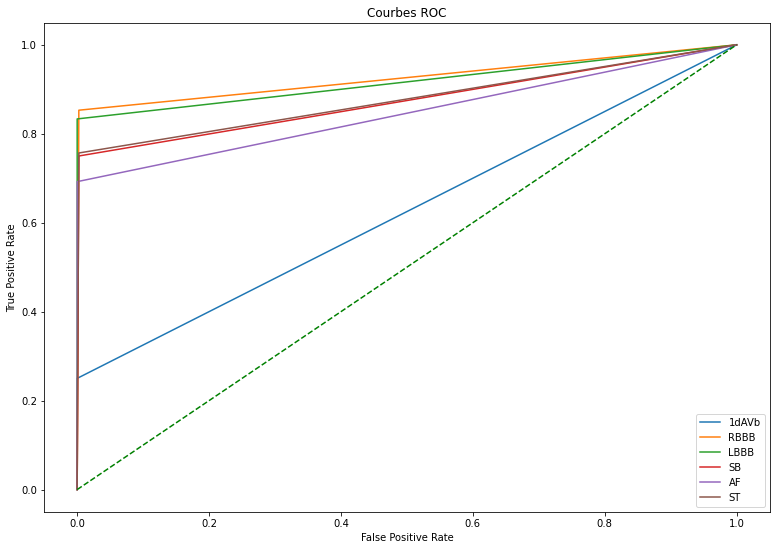

In [107]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = roc_curve(df_gold_s.iloc[:,0],df_predictions_arrondies2.iloc[:,0])
fper2, tper2, thresholds = roc_curve(df_gold_s.iloc[:,1],df_predictions_arrondies2.iloc[:,1])
fper3, tper3, thresholds = roc_curve(df_gold_s.iloc[:,2],df_predictions_arrondies2.iloc[:,2])
fper4, tper4, thresholds = roc_curve(df_gold_s.iloc[:,3],df_predictions_arrondies2.iloc[:,3])
fper5, tper5, thresholds = roc_curve(df_gold_s.iloc[:,4],df_predictions_arrondies2.iloc[:,4])
fper6, tper6, thresholds = roc_curve(df_gold_s.iloc[:,5],df_predictions_arrondies2.iloc[:,5])

plt.plot(fper1, tper1, label='1dAVb')
plt.plot(fper2, tper2, label='RBBB')
plt.plot(fper3, tper3, label='LBBB')
plt.plot(fper4, tper4, label='SB')
plt.plot(fper5, tper5, label='AF')
plt.plot(fper6, tper6, label='ST')

plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()
plt.show()

In [108]:
df_cardio1_global=stats2(df_cardio1)[1]
df_cardio2_global=stats2(df_cardio2)[1]
df_cardior_global=stats2(df_cardior)[1]
df_dnn_global=stats2(df_dnn)[1]
df_emergency_global=stats2(df_emergency)[1]
df_students_global=stats2(df_students)[1]
df_predictions_arrondies2_global=stats2(df_predictions_arrondies2)[1]
df_gold_s_global=stats2(df_cardio1)[2]

In [109]:
cpt=0
for i in df_dnn_global:
    if i ==1:
        cpt+=1
print(cpt)

147


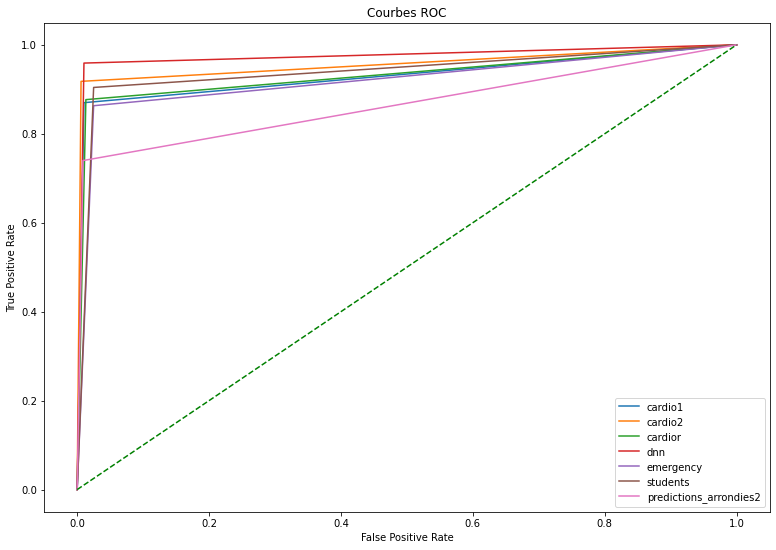

In [110]:
plt.figure(figsize=(13,9))

fper1, tper1, thresholds = roc_curve(df_gold_s_global,df_cardio1_global)
fper2, tper2, thresholds = roc_curve(df_gold_s_global,df_cardio2_global)
fper3, tper3, thresholds = roc_curve(df_gold_s_global,df_cardior_global)
fper4, tper4, thresholds = roc_curve(df_gold_s_global,df_dnn_global)
fper5, tper5, thresholds = roc_curve(df_gold_s_global,df_emergency_global)
fper6, tper6, thresholds = roc_curve(df_gold_s_global,df_students_global)
fper7, tper7, thresholds = roc_curve(df_gold_s_global,df_predictions_arrondies2_global)


plt.plot(fper1, tper1, label='cardio1')
plt.plot(fper2, tper2, label='cardio2')
plt.plot(fper3, tper3, label='cardior')
plt.plot(fper4, tper4, label='dnn')
plt.plot(fper5, tper5, label='emergency')
plt.plot(fper6, tper6, label='students')
plt.plot(fper7, tper7, label='predictions_arrondies2')


plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC')
plt.legend()
plt.show()

### Autres prédictions

In [118]:
df_ndarray2 = np.round(np.load("dnn_output2.npy"),4)
df_predicts2 = pd.DataFrame(data = df_ndarray2, columns = ["MI","HYP","CD","STTC"])
df_predicts2 = df_predicts2.astype(dtype = int)

In [126]:
df_predicts2["STTC"].unique()

array([0])

In [113]:
# x = tf.keras.applications.xception.preprocess_input(x)
# x = model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)  
# outputs = keras.layers.Dense(4)(x)
# model_new = keras.Model(inputs, outputs)

In [ ]:
#  feature = keras.layers.Dense(10)(flatten_1)